<a href="https://colab.research.google.com/github/Rainwoods72/test/blob/main/Chroma_Vector_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chroma Vector Database Tutorial


In [1]:
!pip install -q chromadb transformers #이미지를 vectror로 변환해 huggingface에 있는 모델을 사용하기 위해서 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.7/922.7 kB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.8 MB

## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [2]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

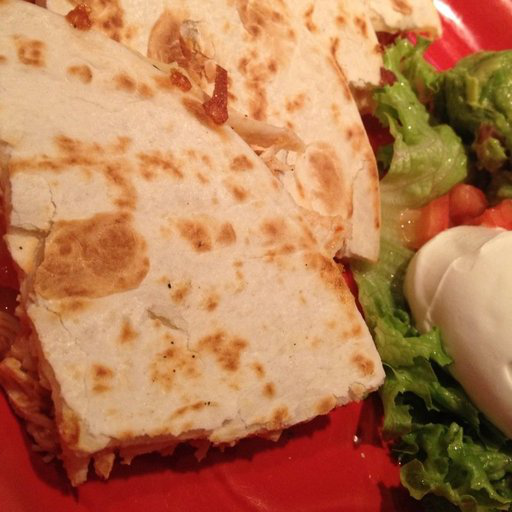

In [3]:
from PIL import Image
img = Image.open("test/Bread/0.jpg")
img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [4]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16') #vision transformer 모델사용 
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [7]:
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze() #최종 pooler_output --> embedding vector 1차원 배열로 변환한다.

embedding #384차원 vector

array([-0.9762277 ,  0.8684666 , -0.81779695, -0.7682566 , -0.21163917,
        0.9786674 ,  0.53969955,  0.98350567, -0.8512179 , -0.63964957,
        0.9906769 ,  0.15667328, -0.20522982, -0.99708205,  0.8860295 ,
       -0.7154037 , -0.7699881 , -0.16147633,  0.91548955,  0.98342514,
       -0.99653506,  0.9455243 ,  0.42391655, -0.9996929 ,  0.9756533 ,
        0.44222558, -0.6223526 , -0.00377832,  0.25929746,  0.8890413 ,
       -0.97052056, -0.93522394, -0.19506522,  0.9497375 ,  0.9845973 ,
        0.1708131 , -0.8865129 ,  0.99218297, -0.20462431,  0.9985602 ,
        0.5404635 , -0.9456166 , -0.6365887 ,  0.61509275,  0.9980995 ,
       -0.41522983,  0.4660852 , -0.97210956,  0.9680894 , -0.9998458 ,
       -0.99044263, -0.9978965 , -0.1312213 ,  0.90187454, -0.0208536 ,
       -0.9920256 ,  0.6652316 ,  0.6219281 ,  0.973791  , -0.85298914,
        0.99982905,  0.6744094 , -0.9981997 , -0.5791434 , -0.96670747,
        0.5584773 ,  0.99882513, -0.97237474, -0.7291742 , -0.94

In [ ]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [6]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods") #foods라는 컬렉션을 만들어줌

## 모든 이미지 벡터화

In [8]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

## 임베딩을 데이터베이스에 저장

In [9]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)): #tqdm은 얼마나 오래 걸리는지를 표시하는 시간
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embeddings.append(embedding.tolist())

    metadatas.append({
        "url": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

100%|██████████| 110/110 [00:02<00:00, 47.51it/s]


Done!


## Test1

In [10]:
import requests

# Load the image
test_img = Image.open("/content/test/download.jpg")
#test_img = Image.open(requests.get("https://i.imgur.com/4I0IhII.jpeg", stream=True).raw).convert("RGB")

test_img

FileNotFoundError: ignored

In [ ]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze() 

test_embedding=test_embedding.tolist()

In [ ]:
query_result = collection.query(
    query_embeddings=test_embedding,
    n_results=3,
)

query_result

{'ids': [['8', '6', '2']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/Bread/8.jpg', 'name': 'Bread'},
   {'url': 'test/Bread/6.jpg', 'name': 'Bread'},
   {'url': 'test/Bread/2.jpg', 'name': 'Bread'}]],
 'distances': [[153.4625244140625, 263.0469665527344, 266.5611877441406]]}

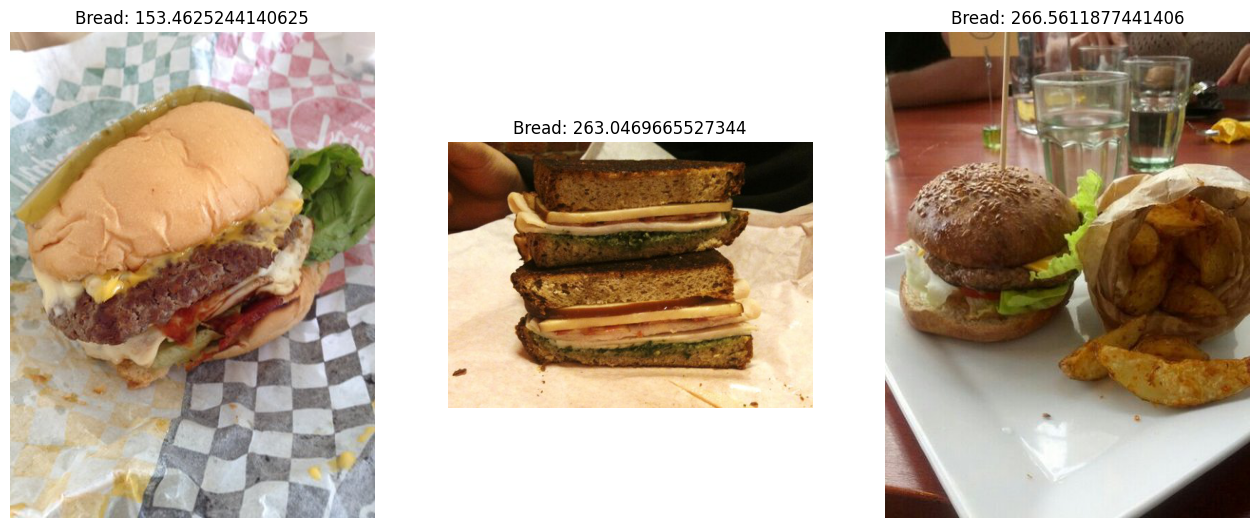

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["url"]))
    axes[i].set_title("{}: {}".format(metadata["name"], distance))
    axes[i].axis("off")

## 테스트를 위한 함수화

In [ ]:
def query(img_url, n_results=3):
    #test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
    test_img = Image.open(img_url)
    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding = test_embedding.tolist()
    query_result = collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["url"]))
        axes[i+1].set_title("{}: {}".format(metadata["name"], distance))
        axes[i+1].axis("off")

    return query_result

## Test2

{'ids': [['8', '6', '2']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'url': 'test/Bread/8.jpg', 'name': 'Bread'},
   {'url': 'test/Bread/6.jpg', 'name': 'Bread'},
   {'url': 'test/Bread/2.jpg', 'name': 'Bread'}]],
 'distances': [[153.4625244140625, 263.0469665527344, 266.5611877441406]]}

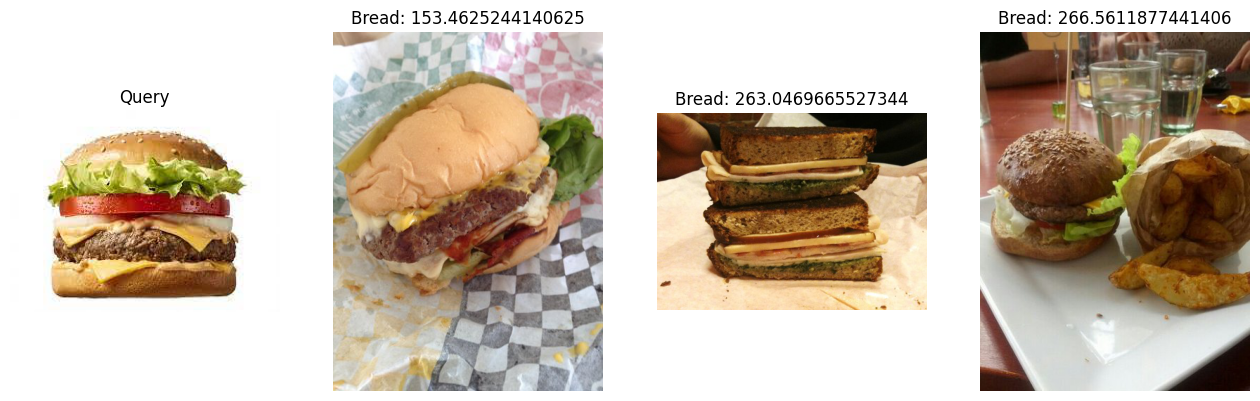

In [ ]:
query("/content/test/download.jpg")